In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics
## Fetching data, training a classifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import scipy as sp
import pandas as pd
import os
loadpath="/Users/sfurlan/Library/CloudStorage/OneDrive-FredHutchinsonCancerCenter/computation/Analysis/viewmastR/pbmc"
Xtrain = sp.io.mmread(os.path.join(loadpath, "scrna/train.mm.gz"))
Xtest = sp.io.mmread(os.path.join(loadpath, "scrna/test.mm.gz"))
Ytrain = pd.read_csv(os.path.join(loadpath, "scrna/train_labels.tsv.gz"), compression = "gzip")
Ytest = pd.read_csv(os.path.join(loadpath, "scrna/test_labels.tsv.gz"), compression = "gzip")
Ytrain = Ytrain['train'].to_numpy()
Ytest = Ytest['test'].to_numpy()


nb = MultinomialNB(alpha=0.001)
nb.fit(Xtrain, Ytrain)
pred = nb.predict(Xtest)
sklearn.metrics.f1_score(Ytest, pred, average='weighted')
import scanpy as sc
import anndata as ad
import matplotlib as plt
samples = {
    "query": os.path.join(loadpath, "scrna/query/3file"),
}
adatas = {}
for sample_id, filename in samples.items():
    sample_adata = sc.read_10x_mtx(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
pca = pd.read_csv(os.path.join(loadpath, "scrna/query/3file/pca_reduction.tsv.gz"), sep='\t', compression="gzip")
umap = pd.read_csv(os.path.join(loadpath, "scrna/query/3file/umap_reduction.tsv.gz"), sep='\t', compression="gzip")
adata.obsm['X_umap'] = umap.iloc[:,[1,2]].to_numpy()
adata.obsm['X_pca'] = pca.iloc[:,1:51].to_numpy()
meta = pd.read_csv(os.path.join(loadpath, "scrna/query/3file/meta.csv"), sep=',')
df2 = adata.obs
meta.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
adata.obs = pd.concat([meta, df2], axis=1)

colors = pd.read_csv(os.path.join(loadpath, "scrna/colors.tsv.gz"), sep=',', compression="gzip")
#print(zip(colors.labels.to_numpy(), colors.colors.to_numpy()))
cmap = dict(zip(colors.labels.to_numpy(), colors.colors.to_numpy()))
#plt.colors.ListedColormap(colors.colors, name=colors.labels)
sc.pl.umap(adata, color = "ground_truth", palette = cmap)





## TorchTensorflow

In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import MaxAbsScaler

# Assuming Xtrain and Xtest are sparse matrices
scaler = MaxAbsScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)
query_scaled = scaler.transform(query)
from sklearn.feature_selection import SelectKBest, chi2

# Assuming your data is non-negative (necessary for chi2)
selector = SelectKBest(chi2, k=1000)  # Select top 1000 features
Xtrain_reduced = selector.fit_transform(Xtrain, Ytrain)
Xtest_reduced = selector.transform(Xtest)
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

# Check if GPU is available and set the device

# if not torch.backends.mps.is_available():
#     if not torch.backends.mps.is_built():
#         print("MPS not available because the current PyTorch install was not "
#               "built with MPS enabled.")
#         device = torch.device("cpu")
#     else:
#         print("MPS not available because the current MacOS version is not 12.3+ "
#               "and/or you do not have an MPS-enabled device on this machine.")
#         device = torch.device("cpu")
# else:
#     mps_device = torch.device("mps")

device = torch.device("cpu")
# Assuming Xtrain and Xtest are sparse matrices in scipy.sparse format, and Ytrain and Ytest are 1D arrays or tensors
Xtraind = torch.tensor(np.asarray(Xtrain_scaled.todense()), dtype=torch.float32).to(device)  # Convert to torch tensor and move to device
Ytraind = torch.tensor(Ytrain - 1, dtype=torch.long).to(device)  # Target tensor and move to device
Xtestd = torch.tensor(np.asarray(Xtest_scaled.todense()), dtype=torch.float32).to(device)  # Convert to torch tensor and move to device
Ytestd = torch.tensor(Ytest - 1, dtype=torch.long).to(device)  # Target tensor and move to device

# Split dataset into training and validation sets
validation_split = 0.2  # Use 20% of data for validation
dataset = TensorDataset(Xtraind, Ytraind)
train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the MLP model with Dropout
class MLPClassifierTorch(nn.Module):
    def __init__(self):
        super(MLPClassifierTorch, self).__init__()
        self.fc1 = nn.Linear(Xtraind.shape[1], 1000)  # First hidden layer with 2000 units
        # self.fc2 = nn.Linear(2000, 300)  # Second hidden layer with 300 units
        self.fc3 = nn.Linear(1000, len(torch.unique(Ytraind)))  # Output layer (adjust output size to number of classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% dropout rate
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first layer
        # x = self.relu(self.fc2(x))
        # x = self.dropout(x)  # Apply dropout after second layer
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer with weight decay (L2 regularization)
model = MLPClassifierTorch().to(device)  # Move the model to the device (GPU or CPU)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Adam optimizer with weight decay

# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

# Test function to evaluate model on test data and return both accuracy and loss
def evaluate_on_test(model, Xtestd, Ytestd):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        test_outputs = model(Xtestd)
        loss = criterion(test_outputs, Ytestd)
        test_loss += loss.item()
        test_accuracy = calculate_accuracy(test_outputs, Ytestd)
    return test_accuracy, test_loss

# Training loop with validation and test evaluation
def train_model(model, train_dataloader, val_dataloader, Xtestd, Ytestd, epochs=20):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        train_accuracy = 0.0
        for batch_X, batch_Y in train_dataloader:
            # Move batches to the device
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Accumulate loss for the current epoch
            epoch_loss += loss.item()

            # Calculate training accuracy for each batch
            train_accuracy += calculate_accuracy(outputs, batch_Y)

        # Compute average training loss and accuracy
        avg_train_loss = epoch_loss / len(train_dataloader)
        train_accuracy /= len(train_dataloader)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():  # No need to track gradients during validation
            for val_batch_X, val_batch_Y in val_dataloader:
                val_batch_X, val_batch_Y = val_batch_X.to(device), val_batch_Y.to(device)

                # Forward pass for validation
                val_outputs = model(val_batch_X)
                loss = criterion(val_outputs, val_batch_Y)
                val_loss += loss.item()

                # Calculate accuracy
                val_accuracy += calculate_accuracy(val_outputs, val_batch_Y)

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = val_accuracy / len(val_dataloader)

        # Evaluate the model on the test data and get test accuracy and loss
        test_accuracy, avg_test_loss = evaluate_on_test(model, Xtestd, Ytestd)

        # Print training, validation, and test metrics for each epoch
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Accuracy: {train_accuracy * 100:.2f}%, '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Test Accuracy: {test_accuracy * 100:.2f}%, '
              f'Test Loss: {avg_test_loss:.4f}, '
              f'Val Accuracy: {avg_val_accuracy * 100:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}')

# Train the model
train_model(model, train_dataloader, val_dataloader, Xtestd, Ytestd, epochs=4)  # Adjust epochs as needed


In [20]:
def predict(model, new_data_sparse, device):
    """
    Function to make predictions on new sparse data using the trained model.
    
    Args:
    - model: Trained PyTorch model.
    - new_data_sparse: New data in sparse matrix form (scipy sparse matrix).
    - device: 'mps' if running on Apple silicon GPU, otherwise 'cpu' or 'cuda'.
    
    Returns:
    - predicted_classes: Tensor of predicted class labels.
    """
    # Convert new sparse matrix data to a dense numpy array
    new_data_dense = torch.tensor(np.asarray(new_data_sparse.todense()), dtype=torch.float32).to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():  # Disable gradient calculations
        # Forward pass: Compute predictions
        outputs = model(new_data_dense)
        
        # Get predicted class (index of the maximum output score)
        _, predicted_classes = torch.max(outputs, 1)
    
    # Move predictions back to CPU (if on MPS) and convert to numpy array
    predicted_classes = predicted_classes.cpu().numpy()
    
    return predicted_classes


adata.obs["torch_pred"] = labels.to_numpy()[predict(model, query, device = 'cpu') ]
sc.pl.umap(adata, color = "torch_pred", palette = cmap)
sklearn.metrics.f1_score(adata.obs['ground_truth'], adata.obs['torch_pred'], average='weighted')

/var/folders/bs/c21jznv97xv0cqtbkz8qb6yw0000gr/T/ipykernel_71634/2734876653.py:2: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Axes: >

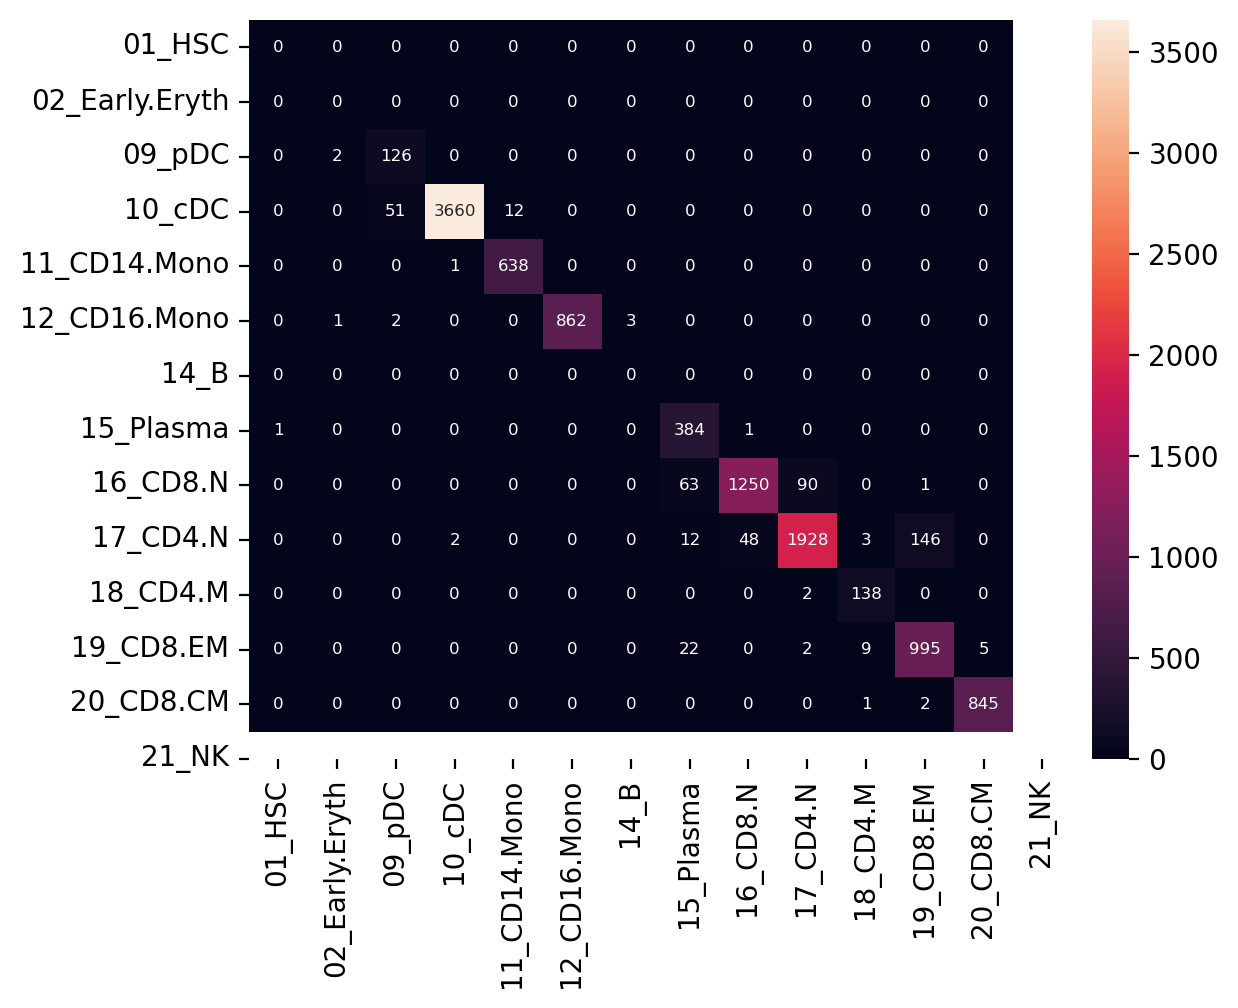

In [114]:
cm = metrics.confusion_matrix(adata.obs['ground_truth'], adata.obs['torch_pred'])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=labs, yticklabels=labs, annot_kws={"size": 6})

## Explaining predictions using lime

In [115]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(nb)

In [116]:
iris = sklearn.datasets.load_iris()
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(iris.data, iris.target, train_size=0.80)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)
sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

0.9333333333333333

In [117]:
#train.shape
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [149]:
from lime.lime_tabular import LimeTabularExplainer
features = pd.read_csv(os.path.join(loadpath, "scrna/features.tsv.gz"), sep='\t', compression="gzip")
features = features['features'].to_numpy()
explainer = lime.lime_tabular.LimeTabularExplainer(Xtrain, feature_names= features, class_names= labels['labels'].to_numpy())


In [325]:

#i = np.random.randint(0, query.shape[0])
#print("i: ", i)
#
adata.obs['ground_truth'] = adata.obs['ground_truth'].astype(str)
adata.obs['nb_pred'] = adata.obs['nb_pred'].astype(str)
adata.obs['viewmastR_pred'] = adata.obs['viewmastR_pred'].astype(str)
#adata.obs['nb_pred']
mm = adata.obs.index[(adata.obs['ground_truth'] != adata.obs['nb_pred']) | (adata.obs['ground_truth'] != adata.obs['viewmastR_pred'])].to_numpy()

adata.obs['mm'] = (adata.obs['ground_truth'] != adata.obs['nb_pred']) | (adata.obs['ground_truth'] != adata.obs['viewmastR_pred'])

In [323]:

j = 2
i = mm[j]
exp = explainer.explain_instance(query.tocsr()[i], nb.predict_proba, num_features=20, top_labels=1, num_samples=1000)
print("True class: ", adata.obs['ground_truth'][i])
print("Naive Bayes Classification: ", adata.obs['nb_pred'][i])
print("ViewmastR Classification: ", adata.obs['viewmastR_pred'][i])
exp.show_in_notebook(show_table=True, show_all=False)

True class:  18_CD4.M
Naive Bayes Classification:  17_CD4.N
ViewmastR Classification:  17_CD4.N


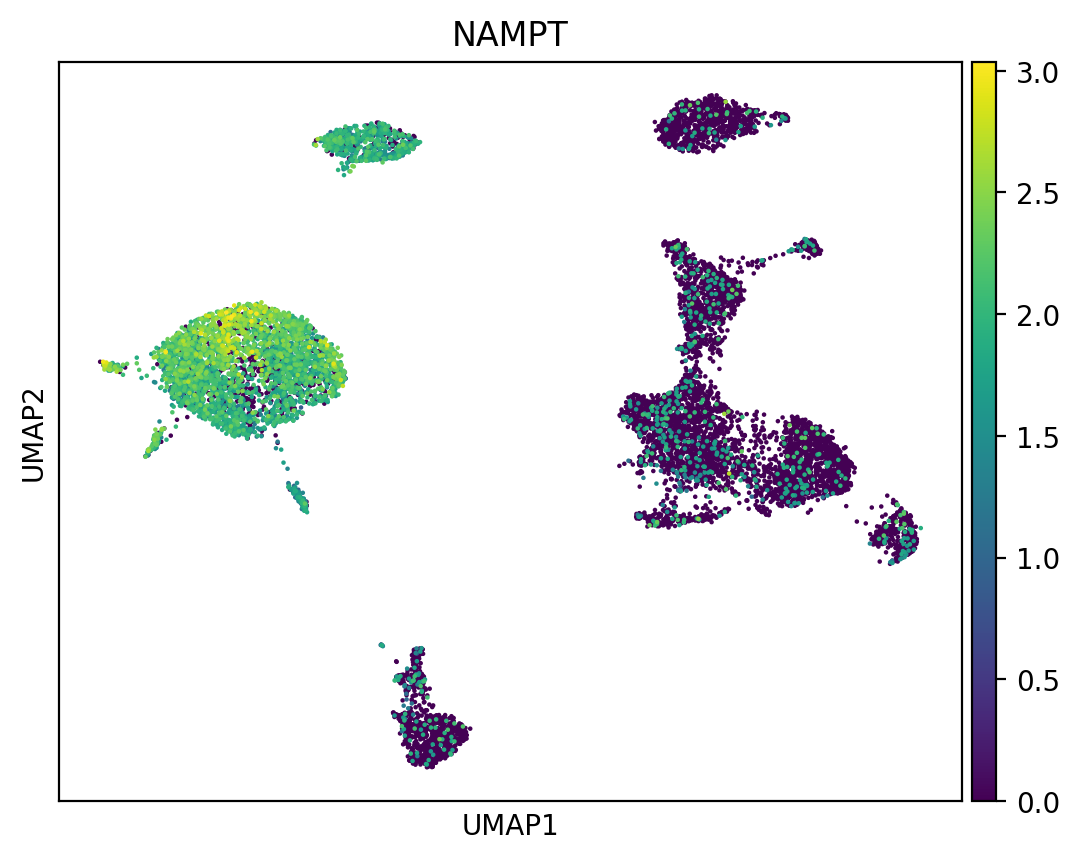

In [287]:
sc.pl.umap(adata, color="NAMPT")

/Users/sfurlan/micromamba/envs/scvelo_jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


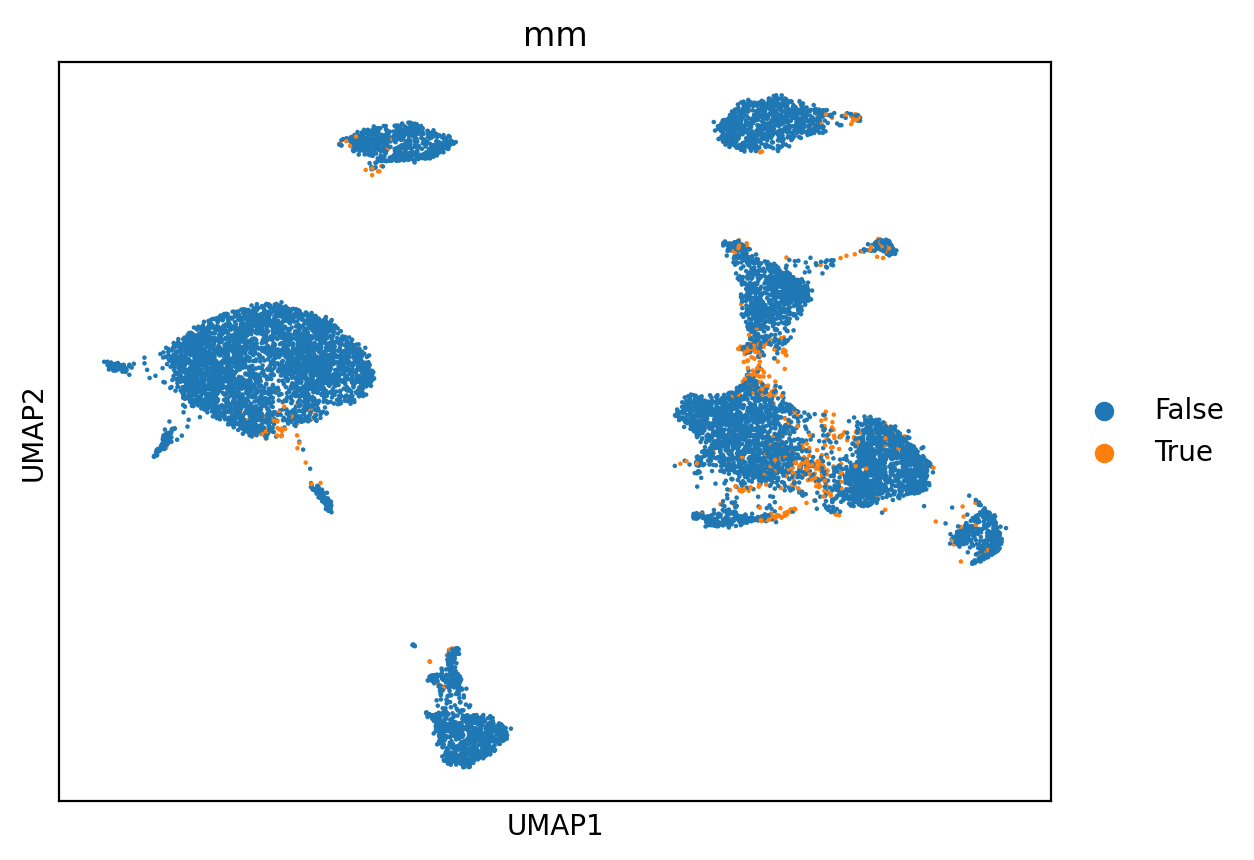

In [328]:
adata.obs['mm'] =  pd.Series(adata.obs['mm'], dtype="category")
sc.pl.umap(adata, color="mm")

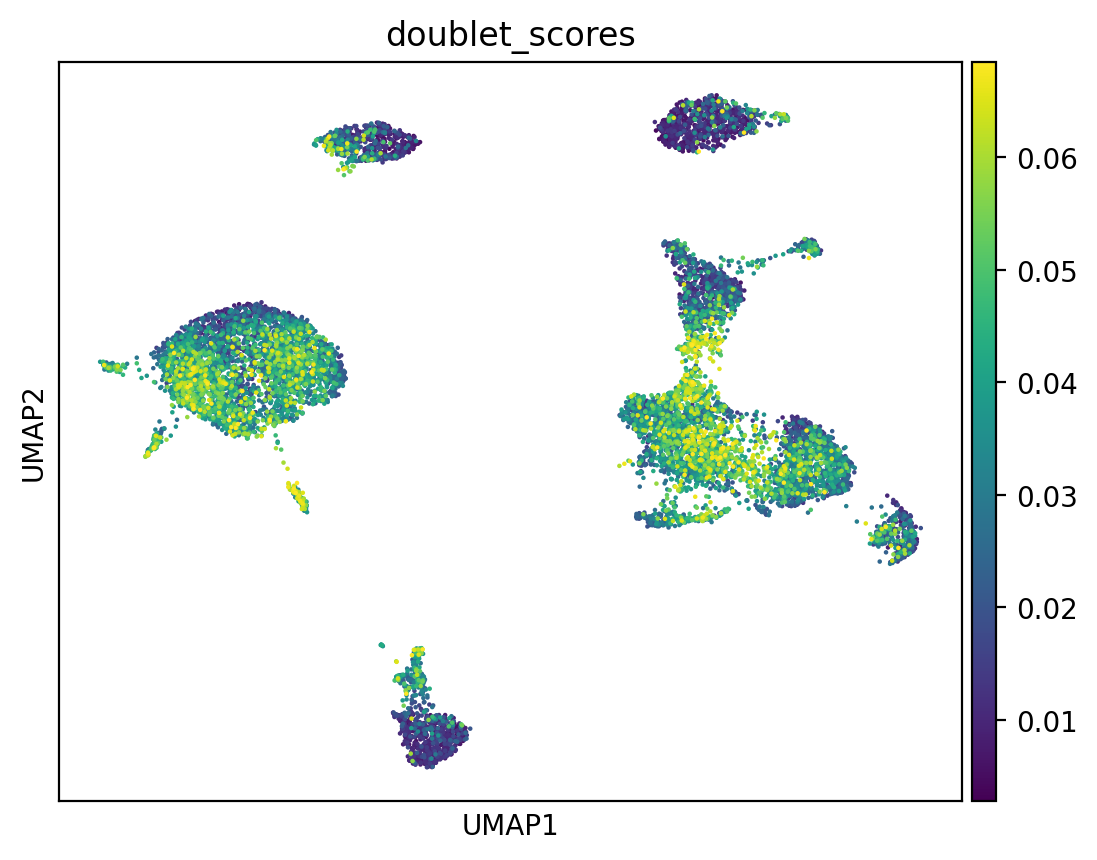

In [330]:
sc.pl.umap(adata, color="doublet_scores")

In [332]:
sc.pp.scrublet(adata, min_counts=3, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)

AttributeError: module 'scanpy.preprocessing' has no attribute 'scrublet'